**Task:- Use a dataset of credit card transactions and
build a model that can identify potentially
fraudulent transactions**

# **1. Importing Libraries**

In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 97% 64.0M/66.0M [00:00<00:00, 190MB/s]
100% 66.0M/66.0M [00:00<00:00, 171MB/s]


In [4]:
!pip install imbalanced-learn

In [5]:
import zipfile
dataset = "/content/creditcardfraud.zip"

with zipfile.ZipFile(dataset, 'r') as zip_ref:
    zip_ref.extractall('extracted_folder')

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
card = pd.read_csv("/content/extracted_folder/creditcard.csv")

In [9]:
card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
card.shape

(284807, 31)

In [11]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [12]:
card.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# **2. Data Checks**

### **2.1 Check for Null Values**

In [13]:
card.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### **2.2 Checks for Unique Values**

In [14]:
card.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

### **2.3 Check for Duplicated Values**

In [15]:
card.duplicated().sum()

1081

In [16]:
card = card.drop_duplicates()

# **3. Exploratory Data Analysis**

### **3.1 Correlation Heatmap**

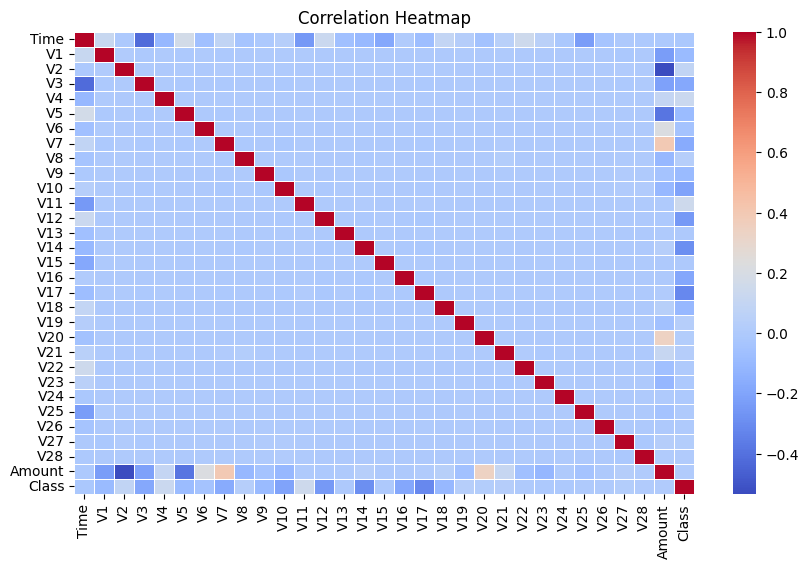

In [17]:
correl = card.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correl, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### **3.2 Lineplot of "Amount"**

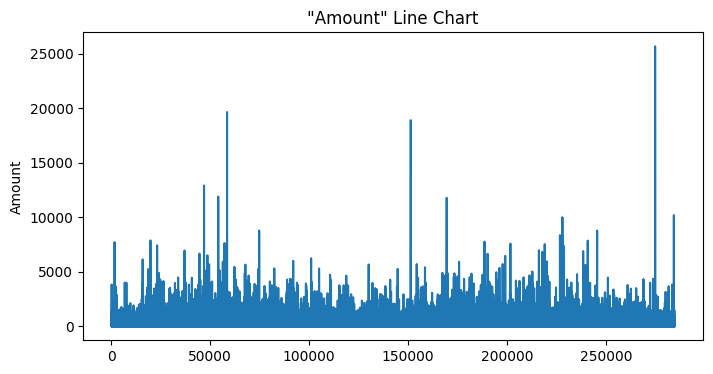

In [18]:
plt.figure(figsize=(8, 4))
sns.lineplot(x=card.index, y=card['Amount'])
plt.title('"Amount" Line Chart')
plt.show()

### **3.3 PieChart for "Class"**

***********************************
Value Distribution
0    283253
1       473
Name: Class, dtype: int64
*****************************
Percentage of Distribution
Class
0    99.83329
1     0.16671
Name: Class, dtype: float64


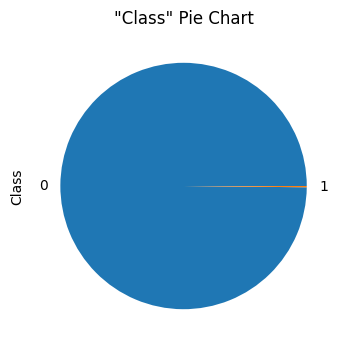

In [19]:
plt.figure(figsize=(8, 4))
print("***********************************")
print("Value Distribution")
print(card["Class"].value_counts())
print("*****************************")
print("Percentage of Distribution")
print((card.groupby('Class')['Class'].count()/card['Class'].count())*100)
((card.groupby('Class')['Class'].count()/card['Class'].count())*100).plot.pie()
plt.title('"Class" Pie Chart')
plt.show()

### **3.4 Description of Dataset on the basis of "Class"**

In [20]:
card.groupby('Class').describe()

Time                                                       \
          count          mean           std    min      25%      50%   
Class                                                                  
0      283253.0  94835.058093  47475.550607    0.0  54233.0  84711.0   
1         473.0  80450.513742  48636.179973  406.0  41203.0  73408.0   

                                 V1            ...       V28             \
            75%       max     count      mean  ...       75%        max   
Class                                          ...                        
0      139308.0  172792.0  283253.0  0.013439  ...  0.077961  33.847808   
1      129095.0  170348.0     473.0 -4.498280  ...  0.372393   1.779364   

         Amount                                                              
          count        mean         std  min   25%    50%     75%       max  
Class                                                                        
0      283253.0   88.413575  250.379023  0.0  5.67  22.00   77.46  25691.16  
1         473.0  123.871860  260.211041  0.0  1.00   9.82  105.89   2125.87  

[2 rows x 240 columns]

### **3.5 Amount vs Class**

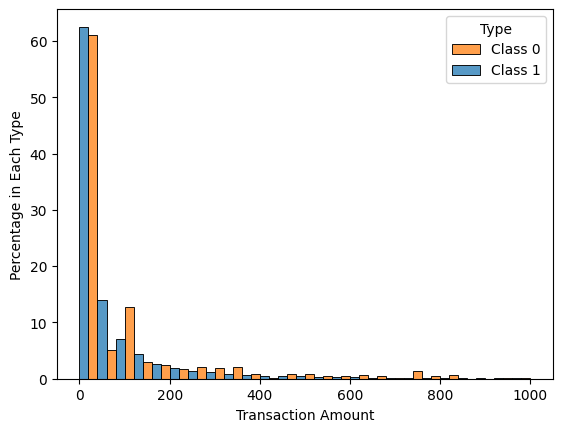

In [21]:
ax=sns.histplot(x='Amount',data=card[card.Amount<=1000],hue='Class',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount')
plt.legend(title='Type', labels=['Class 0', 'Class 1'])

# **4. Data Preparation**

### **4.1 Reduction of the Dataset**

In [22]:
reduced_data = card.sample(n=20000, random_state=42)
reduced_data.to_csv('reduced_dataset.csv', index=False)

In [23]:
reduced_data.shape

(20000, 31)

### **4.2 Identifying Outliers:**

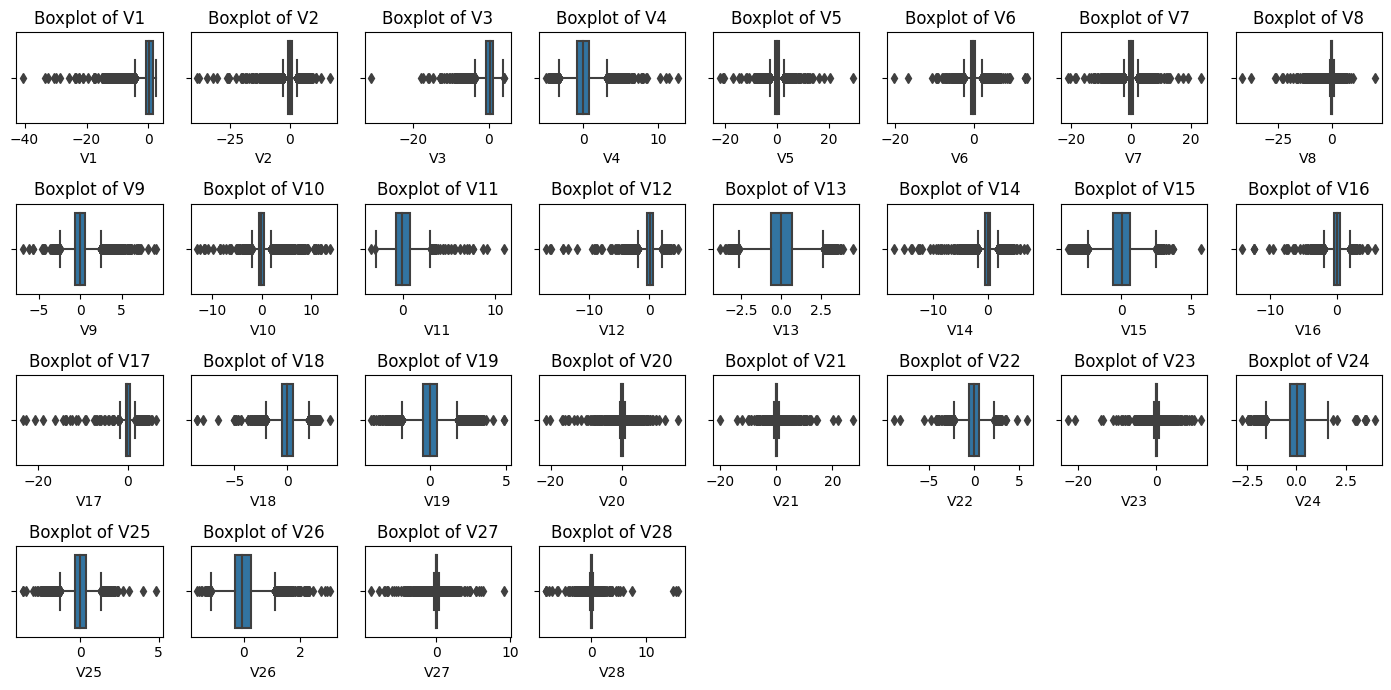

In [24]:
numerical_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                     'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                     'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

plt.figure(figsize=(14, 7))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(4, 8, i)
    sns.boxplot(data=reduced_data, x=column)
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()


**Capping the outliers:**

In [25]:
numerical_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                     'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                     'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

def cap_outliers(df, columns_with_outliers):
    for column in columns_with_outliers:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else x)
        df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else x)

    return df
card = cap_outliers(reduced_data, numerical_columns)

**visualizing boxplot after capping outliers:**

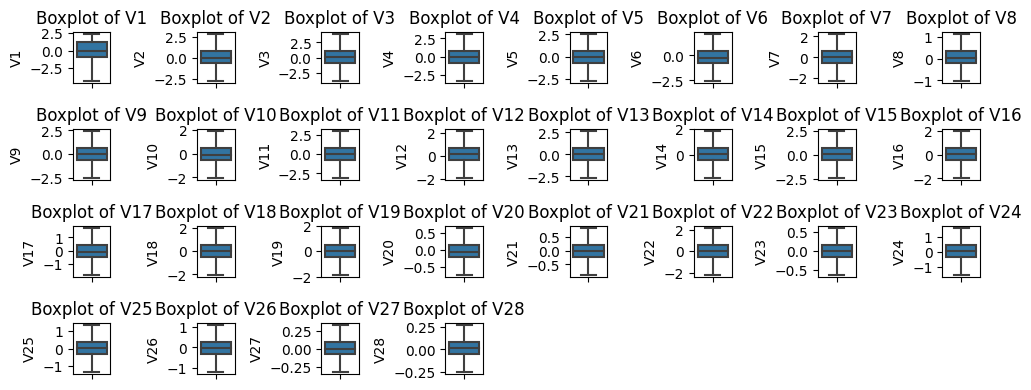

In [26]:
numerical_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                     'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                     'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

plt.figure(figsize=(10, 4))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(4, 8, i)
    sns.boxplot(data=reduced_data, y=column)
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

# **5. Training and Testing Data**

In [27]:
X = reduced_data.drop(['Class','Time'], axis=1)
Y = reduced_data['Class']

rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_resample, Y_resample = rus.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_resample, Y_resample, test_size=0.2, random_state=42)

# **6. Model Training**

### **6.1 Gradient Boosting Classifier**

In [28]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

gradient = GradientBoostingClassifier(random_state=42)
gradient.fit(X_train, Y_train)

print("\t\t\t\tGRADIENT BOOSTING CLASSIFIER\t\t\t\t\n")
gradient_train = gradient.predict(X_train)
print("Accuracy Score on Training Data:", accuracy_score(Y_train, gradient_train))
print("F1 Score on Training Data:", f1_score(Y_train, gradient_train))

print("\n\n*********************\n\n")

gradient_test = gradient.predict(X_test)
print("Accuracy Score on Testing Data:", accuracy_score(Y_test, gradient_test))
print("F1 Score on Testing Data:", f1_score(Y_test, gradient_test))

print("\n\n**********************\n\n")

print("Confusion Matrix:")
print(confusion_matrix(Y_test, gradient_test))

print("\nClassification Report:")
print(classification_report(Y_test, gradient_test))

				GRADIENT BOOSTING CLASSIFIER				

Accuracy Score on Training Data: 1.0
F1 Score on Training Data: 1.0


*********************


Accuracy Score on Testing Data: 0.7857142857142857
F1 Score on Testing Data: 0.7272727272727272


**********************


Confusion Matrix:
[[7 1]
 [2 4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.80      0.67      0.73         6

    accuracy                           0.79        14
   macro avg       0.79      0.77      0.78        14
weighted avg       0.79      0.79      0.78        14



### **6.2 Random Forest Classifier**

In [29]:
rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_std, Y_train)

rf = grid_search.best_estimator_
rf.fit(X_train_std, Y_train)

print("\t\t\tRANDOM FOREST CLASSIFIER\t\t\t\t\n")
rf_train = rf.predict(X_train_std)
print("Accuracy Score on Training Data:", accuracy_score(Y_train, rf_train))
print("F1 Score on Training Data:", f1_score(Y_train, rf_train))

print("\n\n*********************\n\n")

rf_test = rf.predict(X_test_std)
print("Accuracy Score on Testing Data:", accuracy_score(Y_test, rf_test))
print("F1 Score on Testing Data:", f1_score(Y_test, rf_test))

print("\n\n*********************\n\n")

print("Confusion Matrix:")
print(confusion_matrix(Y_test, rf_test))

print("\nClassification Report:")
print(classification_report(Y_test, rf_test))


			RANDOM FOREST CLASSIFIER				

Accuracy Score on Training Data: 1.0
F1 Score on Training Data: 1.0


*********************


Accuracy Score on Testing Data: 0.8571428571428571
F1 Score on Testing Data: 0.8


*********************


Confusion Matrix:
[[8 0]
 [2 4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.67      0.80         6

    accuracy                           0.86        14
   macro avg       0.90      0.83      0.84        14
weighted avg       0.89      0.86      0.85        14



### **6.3 XGBoost Classifier**

In [30]:
xgb = XGBClassifier()
xgb.fit(X_train_std, Y_train)

print("\t\t\t\tXGBOOSTING CLASSIFIER\t\t\t\t\n")
xgb_train = xgb.predict(X_train_std)
print("Accuracy Score on Training Data:", accuracy_score(Y_train, xgb_train))
print("F1 Score on Training Data:", f1_score(Y_train, xgb_train))

print("\n\n*********************\n\n")

xgb_test = xgb.predict(X_test_std)
print("Accuracy Score on Testing Data:", accuracy_score(Y_test, xgb_test))
print("F1 Score on Testing Data:", f1_score(Y_test, xgb_test))

print("\n\n*********************\n\n")

print("Confusion Matrix:")
print(confusion_matrix(Y_test, xgb_test))

print("\nClassification Report:")
print(classification_report(Y_test, xgb_test))

				XGBOOSTING CLASSIFIER				

Accuracy Score on Training Data: 1.0
F1 Score on Training Data: 1.0


*********************


Accuracy Score on Testing Data: 0.8571428571428571
F1 Score on Testing Data: 0.8


*********************


Confusion Matrix:
[[8 0]
 [2 4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.67      0.80         6

    accuracy                           0.86        14
   macro avg       0.90      0.83      0.84        14
weighted avg       0.89      0.86      0.85        14



### **6.4 Support Vector Machine:**

In [31]:
classifier = SVC(kernel='linear')
classifier.fit(X_train_std,Y_train)

print("\t\t\tSUPPORT VECTOR MACHINE\t\t\t\t\n")
classifier_train = classifier.predict(X_train_std)
print("Accuracy Score on Training Data:", accuracy_score(Y_train, classifier_train))
print("F1 Score on Training Data:", f1_score(Y_train, classifier_train))

print("\n\n*********************\n\n")

classifier_test = classifier.predict(X_test_std)
print("Accuracy Score on Testing Data:", accuracy_score(Y_test, classifier_test))
print("F1 Score on Testing Data:", f1_score(Y_test, classifier_test))

print("\n\n*********************\n\n")

print("Confusion Matrix:")
print(confusion_matrix(Y_test, classifier_test))

print("\nClassification Report:")
print(classification_report(Y_test, classifier_test))

			SUPPORT VECTOR MACHINE				

Accuracy Score on Training Data: 1.0
F1 Score on Training Data: 1.0


*********************


Accuracy Score on Testing Data: 0.9285714285714286
F1 Score on Testing Data: 0.9090909090909091


*********************


Confusion Matrix:
[[8 0]
 [1 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.83      0.91         6

    accuracy                           0.93        14
   macro avg       0.94      0.92      0.93        14
weighted avg       0.94      0.93      0.93        14



### **6.5 Logistic Regression:**

In [32]:
model = LogisticRegression()
model.fit(X_train_std,Y_train)

print("\t\t\t\tLOGISTIC REGRESSION\t\t\t\t\n")
model_train = model.predict(X_train_std)
print("Accuracy Score on Training Data:", accuracy_score(Y_train, model_train))
print("F1 Score on Training Data:", f1_score(Y_train, model_train))

print("\n\n*********************\n\n")

model_test = model.predict(X_test_std)
print("Accuracy Score on Testing Data:", accuracy_score(Y_test, model_test))
print("F1 Score on Testing Data:", f1_score(Y_test, model_test))

print("\n\n*********************\n\n")

print("Confusion Matrix:")
print(confusion_matrix(Y_test, model_test))

print("\nClassification Report:")
print(classification_report(Y_test, model_test))

				LOGISTIC REGRESSION				

Accuracy Score on Training Data: 1.0
F1 Score on Training Data: 1.0


*********************


Accuracy Score on Testing Data: 0.9285714285714286
F1 Score on Testing Data: 0.9090909090909091


*********************


Confusion Matrix:
[[8 0]
 [1 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.83      0.91         6

    accuracy                           0.93        14
   macro avg       0.94      0.92      0.93        14
weighted avg       0.94      0.93      0.93        14



**Support Vector Machine and Logistic Regression performed the best as their Test Data accuracy and F1 scores are the highest.**